In [1]:
from __future__ import annotations
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sbn
from typing import Any, List, Type
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
from datetime import datetime
from sklearn.metrics import mean_squared_error
import time
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
import plotly.express as px
from SpatialScan.timeseries import *
from scipy.optimize import minimize
from SpatialScan.preprocessing import *

Using TensorFlow backend.
C:\Users\t_tho\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\t_tho\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\t_tho\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\t_tho\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [2]:
df = pd.read_csv('ActonAprilJune.csv', index_col=False, infer_datetime_format=True, parse_dates=[4, 5])

In [3]:
detectors=df.groupby("detector_id").mean().index.to_numpy()

In [4]:
df_d=df[df["detector_id"]=="N24/131b2" ]

In [5]:
np.percentile(df_d["n_vehicles_in_interval"], 95)

921.2999999999997

In [6]:
DF_d=data_preprocessor(df_d)

detectors dropped:  []tectors


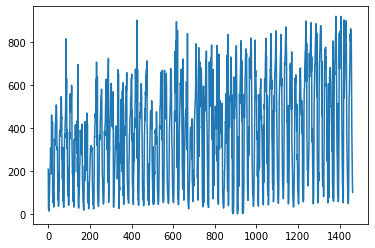

In [8]:
plt.plot(DF_d["n_vehicles_in_interval"].to_numpy())

In [48]:
df_d["n_vehicles_in_interval"].median()+ 3*df_d["n_vehicles_in_interval"].std()


547.3167595608965

In [10]:
Y=count_baseline(df_d, 50, 1, method="HW")

In [11]:
Z=count_baseline(df_d, 50, 1, method="HWO")

In [3]:
DF=data_preprocessor(df)

C:\Users\t_tho\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


KeyboardInterrupt: 

In [10]:
Z=count_baseline(DF, 30, 1, method="HW")

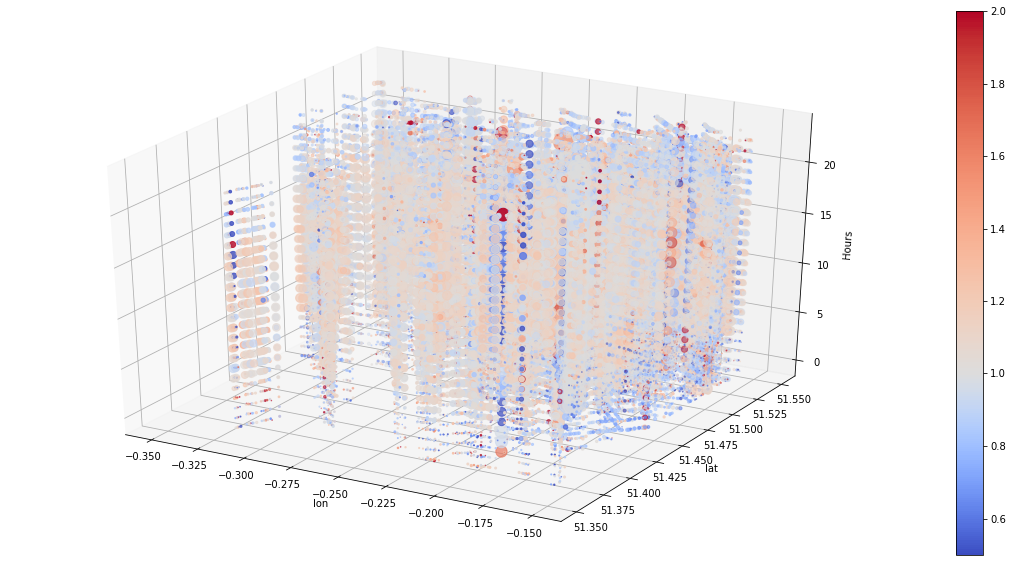

In [11]:
CB_plot(Z)

In [103]:
HW_RSME(params["x"], df_d, 45)

102.01718516513088

In [104]:
HW_RSME([ 0.1 , 0.1,  0.1], df_d, 45)

124.89535390072294

,detector_id,lon,lat,measurement_start_utc,measurement_end_utc,n_vehicles_in_interval
0,N01/036a2,-0.157803,51.512291,2020-06-05 00:00:00,2020-06-05 01:00:00,210.774744
1,N01/036a2,-0.157803,51.512291,2020-06-05 01:00:00,2020-06-05 02:00:00,149.070931
2,N01/036a2,-0.157803,51.512291,2020-06-05 02:00:00,2020-06-05 03:00:00,113.830963
3,N01/036a2,-0.157803,51.512291,2020-06-05 03:00:00,2020-06-05 04:00:00,105.943437
4,N01/036a2,-0.157803,51.512291,2020-06-05 04:00:00,2020-06-05 05:00:00,174.336016
5,N01/036a2,-0.157803,51.512291,2020-06-05 05:00:00,2020-06-05 06:00:00,566.325207
6,N01/036a2,-0.157803,51.512291,2020-06-05 06:00:00,2020-06-05 07:00:00,821.056487
7,N01/036a2,-0.157803,51.512291,2020-06-05 07:00:00,2020-06-05 08:00:00,832.603358
8,N01/036a2,-0.157803,51.512291,2020-06-05 08:00:00,2020-06-05 09:00:00,771.873597
9,N01/036a2,-0.157803,51.512291,2020-06-05 09:00:00,2020-06-05 10:00:00,761.712556


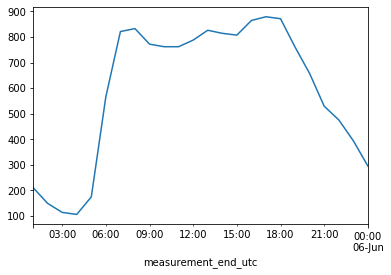

In [28]:
holt_winters(df_d, 45, 1, display=True)

In [39]:
np.sqrt(RSME.mean())

48.83190945269854